In [44]:
import os, random, asyncio, cv2
from pathlib import Path

import torch
from torch.utils.data import random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import config                                 # project config
from models import RewardEstimatorResNet       # trained model

from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset   # dataset class

device = torch.device(config.DEVICE)
print("Using device ➜", device)

Using device ➜ cuda


In [3]:
REWARD_MODEL_OUTPUT_DIR = os.path.join(config.OUTPUT_DIR, "reward_estimator")
BEST_WEIGHTS = os.path.join(REWARD_MODEL_OUTPUT_DIR, "best_reward_estimator_weights.pth")
IMAGE_SIZE    = config.IMAGE_SIZE
N_PREV_FRAMES = config.NUM_PREV_FRAMES        # e.g. 4 → 5-frame input

TRANSFORM = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])
BEST_WEIGHTS

'C:\\Projects\\jetbot-diffusion-world-model-kong-finder-aux\\output_model_small_session_split_data\\reward_estimator\\best_reward_estimator_weights.pth'

In [36]:
def stack_frames(prev_frames: torch.Tensor, current_img: torch.Tensor):
    """Return (3×(N+1),H,W) tensor by concatenating prev+current frames."""
    return torch.cat([prev_frames, current_img], dim=0)


def show_reward_predictions(model, dataset, num_samples=5, title=""):
    """Display random samples with predicted rewards."""
    model.eval()
    idxs = random.sample(range(len(dataset)), num_samples)
    # only pick idxs in the range of the training data
    # idxs = random.sample(range(7000), num_samples)
    print("Dataset Indices")
    print(idxs)
    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(idxs):
        curr, _, prev = dataset[idx]                       # unpack tuple
        stacked = stack_frames(prev, curr).unsqueeze(0).to(device)

        with torch.no_grad():
            reward = model(stacked).item()

        img_disp = T.ToPILImage()(curr.cpu().clamp(0, 1))
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_disp); plt.axis("off")
        plt.title(f"Predicted reward: {reward:.3f}")

    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout(); plt.show()

In [46]:
model = RewardEstimatorResNet(n_frames=N_PREV_FRAMES + 1).to(device)
state = torch.load(BEST_WEIGHTS, map_location=device)
model.load_state_dict(state)
model.eval()
print("Model loaded with",
      sum(p.numel() for p in model.parameters()) / 1e6, "M params")

Model loaded with 11.214657 M params


In [13]:
dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=IMAGE_SIZE,
    num_prev_frames=N_PREV_FRAMES,
    transform=TRANSFORM,
    seed=42,
)
print("Dataset length:", len(dataset))



Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Dataset length: 23037


Dataset Indices
[21702, 19016, 16425, 15555, 19681]


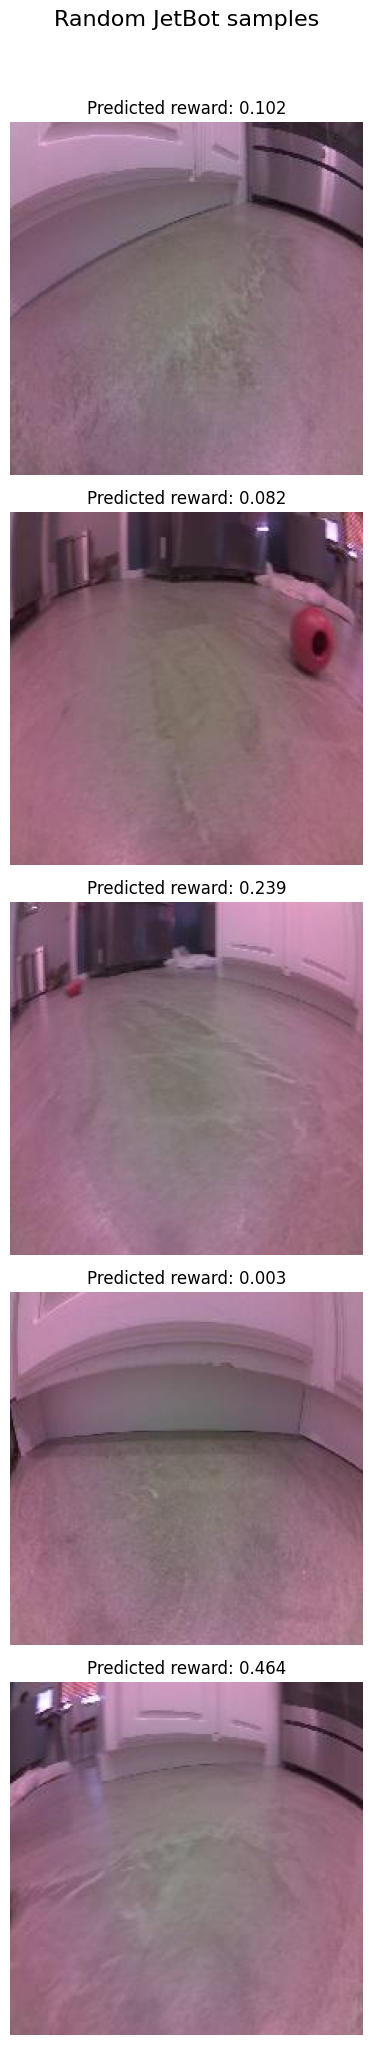

In [43]:
show_reward_predictions(
    model, dataset, num_samples=5, title="Random JetBot samples"
)

In [45]:
# ---------------- Visualise labelled training samples ----------------
def show_training_samples(model, n=5):
    """
    Show *n* random samples that were manually labelled for reward.
    For every sample it renders the current frame together with both
    the ground‑truth reward and the model’s estimate.

    Parameters
    ----------
    model : torch.nn.Module
        A `RewardEstimatorResNet` that is already loaded on the right device.
    n : int
        Number of examples to display.
    """
    import random, os, pandas as pd, torch
    import torchvision.transforms as T
    import matplotlib.pyplot as plt
    from PIL import Image
    import config

    # ------------------------------------------------------------------
    # Paths / hyper‑parameters taken from config so they stay in sync
    # ------------------------------------------------------------------
    MAIN_CSV      = config.CSV_PATH                      # full frames CSV
    REWARD_CSV    = config.MANUAL_COLLECTED_REWARD_CSV   # labels CSV
    DATA_ROOT     = config.DATA_DIR                      # image folder
    N_PREV_FRAMES = config.NUM_PREV_FRAMES               # history length
    IMG_SIZE      = config.IMAGE_SIZE

    device = next(model.parameters()).device
    to_tensor = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

    # ------------------------------------------------------------------
    # Load metadata
    # ------------------------------------------------------------------
    main_df   = pd.read_csv(MAIN_CSV)
    reward_df = pd.read_csv(REWARD_CSV)

    labelled_idxs = reward_df["dataframe_index"].tolist()
    random.shuffle(labelled_idxs)

    shown = 0
    plt.figure(figsize=(6, 4 * n))

    for idx in labelled_idxs:
        if shown == n:
            break
        if idx < N_PREV_FRAMES:
            continue                       # not enough history

        # keep only examples whose whole history belongs to one session
        same_session = (
            main_df.loc[idx, "session_id"]
            == main_df.loc[idx - N_PREV_FRAMES, "session_id"]
        )
        if not same_session:
            continue

        # -------- build the (3·(N+1), H, W) tensor expected by the model
        paths = [
            main_df.loc[idx - off, "image_path"]
            for off in range(N_PREV_FRAMES, -1, -1)
        ]
        frames = [
            to_tensor(Image.open(os.path.join(DATA_ROOT, p)).convert("RGB"))
            for p in paths
        ]
        stacked = torch.cat(frames, dim=0).unsqueeze(0).to(device)

        with torch.no_grad():
            est_reward = model(stacked).item()

        true_reward = float(
            reward_df.loc[reward_df["dataframe_index"] == idx, "assigned_reward"]
            .values[0]
        )
        curr_frame = frames[-1]             # last in the list is current

        plt.subplot(n, 1, shown + 1)
        plt.imshow(T.ToPILImage()(curr_frame.clamp(0, 1).cpu()))
        plt.axis("off")
        plt.title(f"True r = {true_reward:.3f}   |   Est r = {est_reward:.3f}")

        shown += 1

    if shown == 0:
        print("⚠️  No valid labelled samples found ‑ check NUM_PREV_FRAMES & CSVs")
        return

    plt.tight_layout()
    plt.show()


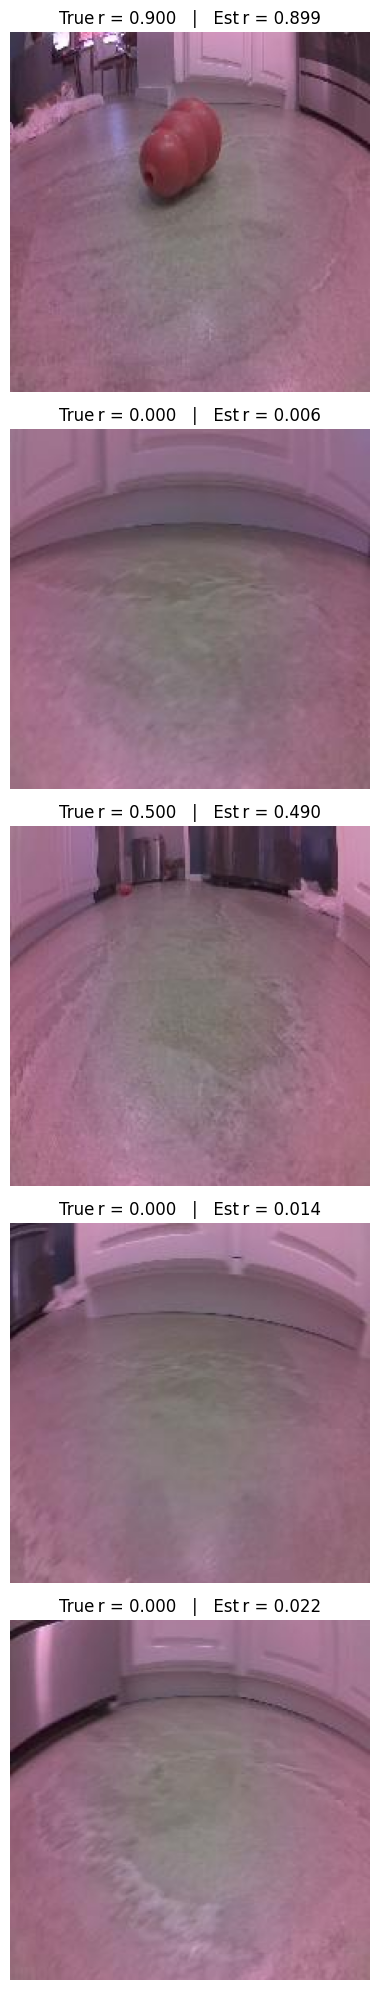

In [52]:
show_training_samples(model, 5)

In [7]:
JETBOT_IP  = "192.168.68.52"   # ← change to your robot’s IP
REFRESH_HZ = 15
from jetbot_remote_client import RemoteJetBot
import ipywidgets as widgets

bot = RemoteJetBot(JETBOT_IP)
print("Connected to JetBot at", JETBOT_IP)

reward_label = widgets.Label(value="Reward: ---")
display(reward_label)

prev_buf = []                       # holds the last N_PREV_FRAMES *previous* frames

async def live_loop():
    global prev_buf
    while True:
        bgr = bot.get_frame()
        if bgr is not None:
            rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            pil  = Image.fromarray(rgb)
            curr = TRANSFORM(pil)                # (3, H, W)

            # --------------------------------------------------------
            # Maintain buffer of *previous* frames (not including curr)
            # --------------------------------------------------------
            if len(prev_buf) == N_PREV_FRAMES:
                prev_buf.pop(0)                  # drop oldest
            prev_buf.append(curr)

            if len(prev_buf) == N_PREV_FRAMES:   # we now have N prev + curr
                prev_tensor = torch.cat(prev_buf, dim=0)       # (3N, H, W)
                stacked     = torch.cat([prev_tensor, curr],   # (3N+3, H, W)
                                         dim=0).unsqueeze(0).to(device)

                with torch.no_grad():
                    r = model(stacked).item()
                reward_label.value = f"Reward: {r:.3f}"

        await asyncio.sleep(1 / REFRESH_HZ)

await live_loop()


INFO:JetBotClient:Connecting to JetBot at 192.168.68.52:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

Connected to JetBot at 192.168.68.52


Label(value='Reward: ---')

CancelledError: 